In [ ]:
!pip install ultralytics albumentations opencv-python-headless scikit-learn tqdm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.7 MB/s eta 0:00:00


In [ ]:
import os

raw_dataset_path = "/content/drive/MyDrive/data/raw"  # Update this if needed
yolo_dataset_path = "/content/data/yolo_format"
os.makedirs(yolo_dataset_path, exist_ok=True)


In [ ]:
import cv2
import random
import albumentations as A
from tqdm import tqdm
from sklearn.model_selection import train_test_split

IMG_SIZE = (640, 640)

# Define transformations (augmentations)
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
])

def preprocess_image(img_path, augment=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment:
        augmented = transform(image=img)
        img = augmented['image']

    img = cv2.resize(img, IMG_SIZE)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.bilateralFilter(img, 9, 75, 75)

    return img

def save_yolo_format(img, label, output_path, label_idx):
    img_path = os.path.join(output_path, "images")
    label_path = os.path.join(output_path, "labels")

    os.makedirs(img_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)

    filename = os.path.basename(label[1])
    name, _ = os.path.splitext(filename)
    img_file = os.path.join(img_path, filename)
    label_file = os.path.join(label_path, f"{name}.txt")

    cv2.imwrite(img_file, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    cx, cy, width, height = 0.5, 0.5, 1.0, 1.0
    with open(label_file, "w") as f:
        f.write(f"{label_idx} {cx} {cy} {width} {height}\n")

def prepare_dataset(input_dir, output_dir):
    all_images = []
    class_map = {}
    class_id = 0

    for cls in sorted(os.listdir(input_dir)):
        class_map[cls] = class_id
        class_dir = os.path.join(input_dir, cls)
        for img_file in os.listdir(class_dir):
            all_images.append((class_id, os.path.join(class_dir, img_file)))
        class_id += 1

    random.shuffle(all_images)
    train, test = train_test_split(all_images, test_size=0.2, stratify=[x[0] for x in all_images])
    val, test = train_test_split(test, test_size=0.5)

    for subset, name in zip([train, val, test], ['train', 'val', 'test']):
        subset_path = os.path.join(output_dir, name)
        for label in tqdm(subset, desc=f"Processing {name} set"):
            img = preprocess_image(label[1], augment=(name == 'train'))
            save_yolo_format(img, label, subset_path, label[0])

prepare_dataset(raw_dataset_path, yolo_dataset_path)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Processing test set: 100%|██████████| 195/195 [01:16<00:00,  2.55it/s]


In [ ]:
dataset_yaml = f"""
path: {yolo_dataset_path}
train: train/images
val: val/images

nc: 15
names: [Bear, Bird, Cat, Cow, Deer, Dog, Dolphin, Elephant, Giraffe, Horse, Kangaroo, Lion, Panda, Tiger, Zebra]
"""

with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml created")


✅ dataset.yaml created


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data='dataset.yaml',
    epochs=100,
    patience=10,
    imgsz=640,
    project='runs',
    name='animal-yolo',
    exist_ok=True  ,  optimizer='AdamW', # Changed optimizer
    lr0=0.001
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs, name=animal-yolo, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1483.8±594.7 MB/s, size: 65.2 KB)


train: Scanning /content/data/yolo_format/train/labels... 1555 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1555/1555 [00:00<00:00, 2194.10it/s]

train: New cache created: /content/data/yolo_format/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 539.4±657.5 MB/s, size: 60.4 KB)


val: Scanning /content/data/yolo_format/val/labels... 194 images, 0 backgrounds, 0 corrupt: 100%|██████████| 194/194 [00:00<00:00, 1070.29it/s]

val: New cache created: /content/data/yolo_format/val/labels.cache


Plotting labels to runs/animal-yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/animal-yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.14G     0.2982      2.772      1.062         12        640: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        194        194      0.208      0.739      0.173      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.63G      0.186      2.207     0.9592          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        194        194       0.32      0.348      0.274      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.65G     0.1784      2.063     0.9508          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        194        194      0.169      0.534      0.323      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.66G     0.1683      1.963     0.9496          9        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        194        194      0.215      0.568       0.36      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.68G     0.1598      1.892     0.9408          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        194        194      0.621      0.387      0.375      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.69G     0.1548      1.815     0.9363          9        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        194        194      0.294      0.452      0.377      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.72G     0.1384       1.76     0.9216         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        194        194      0.335      0.612      0.478      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.73G     0.1341      1.744     0.9236         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        194        194       0.52      0.543      0.517      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.75G      0.123      1.693     0.9205          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        194        194      0.346      0.614      0.482      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.76G     0.1204       1.63     0.9189         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        194        194      0.398      0.551      0.513       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.79G     0.1123      1.633     0.9157          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        194        194      0.456      0.615      0.524      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.8G     0.1129      1.597     0.9154          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


                   all        194        194      0.427      0.649      0.599      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.82G     0.1125      1.574     0.9096          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        194        194      0.406       0.66       0.57      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.83G     0.1054      1.517     0.9087          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        194        194      0.428      0.586      0.573       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.86G      0.109      1.473     0.9144         11        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        194        194      0.502       0.62      0.625      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.86G     0.1093      1.442     0.9181          5        640: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        194        194      0.538      0.657      0.634      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.89G    0.09843      1.434      0.907         12        640: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        194        194      0.482      0.666      0.631      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.9G     0.1022       1.43     0.9091          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        194        194      0.572      0.685      0.695      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.92G    0.09995      1.408     0.9117         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        194        194      0.568      0.673      0.701      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.93G    0.09849      1.388     0.9066         12        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        194        194      0.686      0.447      0.611      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.96G     0.0951      1.344     0.9022          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        194        194      0.719      0.707      0.767      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.97G    0.09212      1.355     0.9068          9        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        194        194      0.656      0.686      0.743      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.99G    0.08764      1.338      0.902          9        640: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        194        194      0.588      0.755      0.749      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         3G    0.08623      1.298     0.9004         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        194        194      0.615      0.792      0.767      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.03G    0.08573      1.329     0.9081          8        640: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        194        194      0.669      0.767      0.808      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.04G    0.08533       1.27      0.903          9        640: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        194        194      0.659      0.737      0.755      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.06G    0.08687      1.274     0.9093          8        640: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        194        194      0.644      0.689       0.75       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.07G    0.08634      1.238     0.9055          7        640: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        194        194      0.679      0.734      0.791      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.09G    0.08278      1.224     0.9009         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        194        194      0.704      0.738       0.79      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.1G     0.0805      1.194     0.9043         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        194        194      0.817      0.547      0.715      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.13G    0.07981       1.18     0.9041          8        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        194        194      0.636      0.648       0.75      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.14G    0.07965      1.195     0.8993         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        194        194      0.639      0.724      0.764      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.16G    0.07911      1.168     0.8968         12        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        194        194      0.731      0.776      0.814      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.17G    0.07517       1.16     0.9003          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        194        194      0.899      0.745      0.883      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.2G    0.07728      1.161     0.8974         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        194        194       0.73      0.826      0.868      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.21G    0.07433      1.124     0.8991         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        194        194      0.829      0.755       0.86      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.23G    0.07461      1.104     0.8975         11        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        194        194       0.91      0.792      0.896      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.24G    0.07362      1.092     0.8985          7        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        194        194      0.865      0.814      0.901        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.27G    0.07006      1.085      0.898          9        640: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        194        194      0.847      0.756      0.872      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.28G    0.07311       1.05     0.8956         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        194        194       0.85       0.74      0.859      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       3.3G    0.07164      1.035     0.8963         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        194        194      0.882      0.777      0.898      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.31G    0.06912      1.029     0.8998         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        194        194      0.901      0.832      0.933      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.33G    0.07158      1.068        0.9         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        194        194      0.837      0.791      0.905      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.34G    0.06984      1.028     0.8956         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        194        194       0.87      0.809      0.929      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.37G    0.06869     0.9939     0.8981         12        640: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        194        194      0.866       0.89      0.938      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.38G    0.06681     0.9692     0.8877          7        640: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        194        194      0.879      0.803      0.914      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.4G    0.07846      1.011     0.9072          5        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        194        194      0.865      0.748      0.912      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.41G    0.06982     0.9736     0.8958          9        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        194        194      0.913       0.85      0.945      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.44G    0.07056     0.9772      0.899         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        194        194      0.828      0.896      0.926      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.45G    0.06974     0.9608     0.8935         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        194        194      0.821      0.798      0.906      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.47G    0.07031     0.9485     0.8976         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        194        194      0.905      0.809      0.928      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.48G    0.06691     0.9344     0.8928          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        194        194      0.886      0.839       0.93       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.5G    0.06281     0.9066     0.8958          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        194        194      0.904      0.898      0.959      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.51G    0.06231     0.8916     0.8919         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        194        194        0.9      0.886      0.952      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.54G    0.06223     0.9147     0.8953          9        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        194        194      0.867      0.891      0.949      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.55G    0.06129     0.8705     0.8907          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        194        194      0.871      0.878      0.937      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.57G    0.05916     0.8643     0.8927          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        194        194      0.908      0.884      0.956      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.58G      0.061     0.8602     0.8922          8        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        194        194      0.883      0.882      0.957      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.61G    0.05948     0.8474     0.8945         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        194        194      0.923      0.861      0.955      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.62G    0.05979     0.8506     0.8933         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        194        194      0.925       0.92      0.974      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.64G    0.05767      0.862     0.8933         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        194        194      0.878      0.944       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.65G    0.05689     0.8101     0.8972         10        640: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        194        194      0.907      0.919      0.967      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.68G     0.0588     0.8398     0.8924          8        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        194        194       0.97      0.887       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.69G    0.05707     0.7856     0.8904         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        194        194      0.909      0.957       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.71G    0.05735     0.8125     0.8936         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        194        194      0.909      0.931      0.969      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.72G    0.05629     0.7939     0.9012          9        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        194        194      0.947      0.879      0.964      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.74G    0.05526     0.7927     0.8886         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        194        194      0.952      0.913      0.979      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.75G    0.05305     0.8019      0.894          7        640: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        194        194      0.947       0.95      0.977      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.78G     0.0521     0.7846     0.8848          4        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        194        194      0.945      0.931      0.977      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.79G    0.05085     0.7651     0.8943          9        640: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        194        194      0.933      0.887       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.81G    0.05151     0.7613     0.8916          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        194        194      0.962      0.933      0.981      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.82G    0.05305     0.7494     0.8925         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        194        194      0.926      0.936      0.976      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.85G    0.04858     0.7281     0.8868         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        194        194      0.964      0.943      0.987      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.86G    0.04957     0.7486     0.8872         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        194        194      0.972      0.928      0.983      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.88G    0.05164     0.7375     0.8897          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        194        194      0.965      0.943      0.983      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.89G    0.04885     0.7594     0.8899         11        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        194        194      0.968       0.93      0.981       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.91G    0.04804     0.7058      0.892          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        194        194      0.975      0.946       0.98       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.92G    0.05013     0.7256     0.8917          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        194        194      0.977      0.947      0.988      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.95G    0.04765     0.7194     0.8901          7        640: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        194        194      0.959      0.958      0.984      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.96G    0.04776     0.7046     0.8884         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        194        194      0.957      0.954      0.984      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.98G    0.04498     0.6896     0.8845          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        194        194      0.955      0.937      0.979      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.99G    0.04574     0.6787     0.8881         10        640: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        194        194      0.948      0.916      0.974      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.02G    0.04488      0.667     0.8924          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        194        194      0.964      0.964      0.987      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.03G    0.04565     0.6509     0.8946          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        194        194      0.975      0.938      0.987      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.05G    0.04202     0.6661     0.8963         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        194        194      0.954      0.957      0.983      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.06G    0.04232     0.6452     0.8885          8        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


                   all        194        194      0.972       0.95      0.986      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.09G    0.04324     0.6792      0.889          9        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        194        194      0.963      0.969      0.988      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       4.1G    0.04051      0.651     0.8885         12        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        194        194      0.948       0.97      0.983      0.983
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 78, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



88 epochs completed in 0.803 hours.
Optimizer stripped from runs/animal-yolo/weights/last.pt, 6.3MB
Optimizer stripped from runs/animal-yolo/weights/best.pt, 6.3MB

Validating runs/animal-yolo/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                   all        194        194      0.977      0.947      0.988      0.988
                  Bear         12         12          1      0.923      0.995      0.995
                  Bird         15         15      0.991          1      0.995      0.995
                   Cat         14         14      0.989          1      0.995      0.995
                   Cow         11         11      0.977      0.636      0.951      0.951
                  Deer         16         16      0.942      0.938      0.991      0.991
                   Dog         17         17       0.99      0.941      0.992      0.992
               Dolphin         15         15      0.999          1      0.995      0.995
              Elephant         10         10      0.874        0.9      0.954      0.954
               Giraffe         17         17      0.993          1      0.995      0.995
                 Horse         12         12      0.985          1      0.995      0.995
              Kangaro

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bef8dffdc50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

Saving dol.jpeg to dol.jpeg

📸 Uploaded file: dol.jpeg


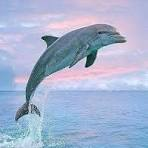


0: 640x640 1 Dolphin, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


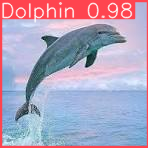

✅ Detected: Dolphin (98.30% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving dog.jpeg to dog.jpeg

📸 Uploaded file: dog.jpeg


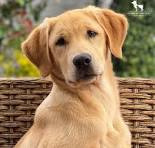


0: 640x640 1 Dog, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


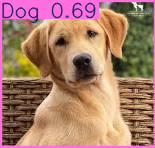

✅ Detected: Dog (69.39% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving zeb.jpeg to zeb.jpeg

📸 Uploaded file: zeb.jpeg


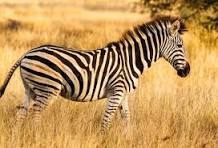


0: 448x640 1 Zebra, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


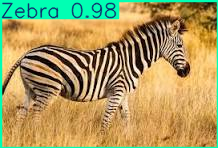

✅ Detected: Zebra (98.10% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving ele.jpeg to ele.jpeg

📸 Uploaded file: ele.jpeg


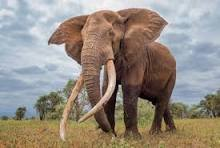


0: 448x640 1 Elephant, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


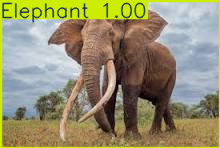

✅ Detected: Elephant (99.78% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving kang.jpeg to kang.jpeg

📸 Uploaded file: kang.jpeg


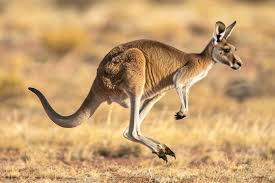


0: 448x640 1 Kangaroo, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


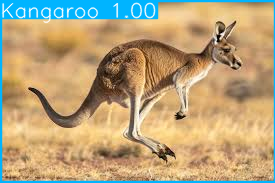

✅ Detected: Kangaroo (99.90% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving tig.jpeg to tig.jpeg

📸 Uploaded file: tig.jpeg


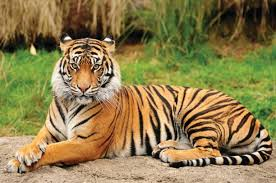


0: 448x640 1 Tiger, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


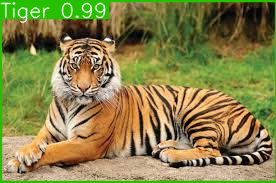

✅ Detected: Tiger (99.25% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving panda.jpeg to panda.jpeg

📸 Uploaded file: panda.jpeg


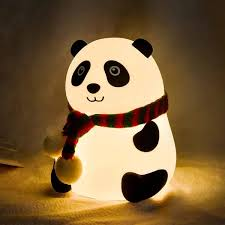


0: 640x640 (no detections), 27.9ms
Speed: 12.6ms preprocess, 27.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


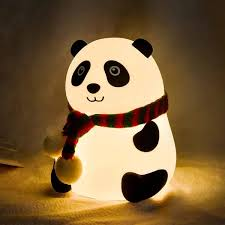

In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")



Saving pan.jpeg to pan.jpeg

📸 Uploaded file: pan.jpeg


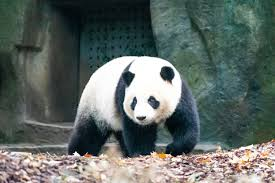


0: 448x640 1 Panda, 17.1ms
Speed: 2.9ms preprocess, 17.1ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)


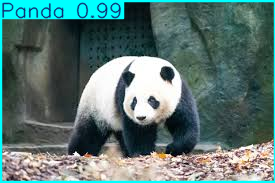

✅ Detected: Panda (99.35% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving gir.jpeg to gir.jpeg

📸 Uploaded file: gir.jpeg


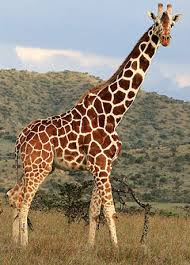


0: 640x480 1 Giraffe, 42.4ms
Speed: 2.4ms preprocess, 42.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


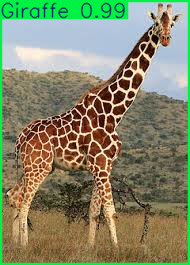

✅ Detected: Giraffe (99.00% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving hor.jpeg to hor.jpeg

📸 Uploaded file: hor.jpeg


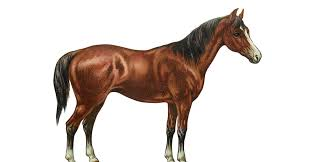


0: 352x640 1 Horse, 67.8ms
Speed: 2.5ms preprocess, 67.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


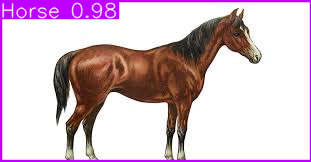

✅ Detected: Horse (97.60% confidence)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt

# Load the detection model (detection, not classification)
model = YOLO('runs/animal-yolo/weights/best.pt')

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Uploaded file: {filename}")

    # Load image
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)

    # Perform detection
    results = model(image)

    # Show results with bounding boxes
    results[0].show()

    # Print all detections
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")


Saving deer.jpeg to deer.jpeg


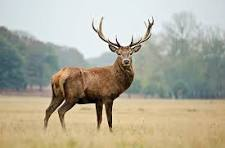


0: 448x640 1 Giraffe, 42.1ms
Speed: 2.8ms preprocess, 42.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


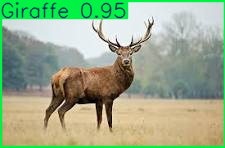

✅ Detected: Giraffe (95.30% confidence)


In [ ]:
from google.colab import files
from PIL import Image
import io

model = YOLO('runs/animal-yolo/weights/best.pt')
uploaded = files.upload()

for filename in uploaded:
    image = Image.open(io.BytesIO(uploaded[filename]))
    display(image)
    results = model(image)

    results[0].show()

    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = results[0].names[class_id]
        confidence = float(box.conf[0])
        print(f"✅ Detected: {class_name} ({confidence*100:.2f}% confidence)")
